Bu laboratuvarda, bu bölümde tartışılan birçok tekniği uygularız. Bazı kütüphanelerimizi bu üst seviyede (en başta) içe aktarırız.

In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial

Bu laboratuvar için gerekli olan yeni kütüphane importlarını tekrar topluyoruz.


In [2]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
(Stepwise,
sklearn_selected,
sklearn_selection_path)
!pip install l0bnb -q
from l0bnb import fit_path


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


`l0bnb` paketini çalıştırma sırasında anlık olarak (on the fly) yükledik. Dikkat edin, `!pip install` kaçışlı şekilde (`escaped`) kullanılmıştır — bu ayrı bir sistem komutu olarak çalıştırılır.

# 6.5.1 Alt Küme Seçim Yöntemleri (Subset Selection Methods)

Burada, bir modeli giriş değişkenlerinin bir alt kümesine kısıtlayarak parametre sayısını azaltan yöntemleri uygularız.

## İleri Seçim (Forward Selection)

İleri seçim yaklaşımını **Hitters** verisi üzerinde uygulayacağız. Amacımız, bir beyzbol oyuncusunun maaşını (Salary) önceki yılki performansla ilişkili çeşitli istatistiklere dayanarak tahmin etmektir.

Öncelikle, bazı oyuncular için **Salary** değişkeninin eksik olduğunu not ediyoruz. Eksik gözlemleri belirlemek için `np.isnan()` fonksiyonu kullanılabilir. Bu fonksiyon, giriş vektörüyle aynı şekle sahip bir dizi döndürür; eksik olan öğeler için `True`, eksik olmayanlar için `False` değerini içerir. Daha sonra tüm eksik öğeleri saymak için `sum()` yöntemi kullanılabilir.

In [3]:
Hitters = load_data('Hitters')
np.isnan(Hitters['Salary']).sum()

59

Salary değişkeninin 59 oyuncu için eksik olduğunu görüyoruz. Veri çerçevelerinin **dropna()** yöntemi, varsayılan olarak herhangi bir değişkende eksik değeri olan tüm satırları kaldırır (bkz. `Hitters.dropna?`).


In [4]:
Hitters = Hitters.dropna();
Hitters.shape

(263, 20)

İlk olarak, **Cp** (6.2) temel alınarak ileri seçim yöntemiyle en iyi modeli seçiyoruz. Bu skor, sklearn içinde yerleşik bir metrik olarak bulunmamaktadır. Bu nedenle, Cp’yi kendimiz hesaplayan bir fonksiyon tanımlar ve bunu bir **scorer** olarak kullanırız. Sklearn varsayılan olarak skoru maksimize etmeye çalıştığından, bizim scoring fonksiyonumuz negatif Cp istatistiğini hesaplar.


In [5]:
def nCp(sigma2, estimator, X, Y):
 "Negative Cp statistic"
 n, p = X.shape
 Yhat = estimator.predict(X)
 RSS = np.sum((Y- Yhat)**2)
 return -(RSS + 2 * p * sigma2) / n

Artık varyansını (σ²) tahmin etmemiz gerekiyor; bu yukarıdaki skor fonksiyonundaki ilk argümandır. Tüm değişkenleri kullanarak en büyük modeli kuracağız ve σ²’yi MSE’si üzerinden tahmin edeceğiz.

In [6]:
design = MS(Hitters.columns.drop('Salary')).fit(Hitters)
Y = np.array(Hitters['Salary'])
X = design.transform(Hitters)
sigma2 = OLS(Y,X).fit().scale

sklearn_selected() fonksiyonu, yalnızca üç argüman alan bir skorer bekliyor — yukarıda nCp() fonksiyonunun tanımındaki son üç argüman. İlk argümanı σ² tahminimizle sabitlemek için Bölüm 5.3.3’te ilk kez gördüğümüz partial() fonksiyonunu kullanıyoruz.


In [7]:
neg_Cp = partial(nCp, sigma2)

Artık neg_Cp()’yi model seçimi için bir skorer olarak kullanabiliriz. Skorla birlikte arama stratejisini de belirtmemiz gerekir. Bu, ISLP.models paketindeki Stepwise() nesnesi ile yapılır. Stepwise.first_peak() yöntemi, modele daha fazla ekleme yapılmasının değerlendirme skorunda bir iyileşme sağlamadığı noktaya kadar ileriye doğru stepwise çalıştırır. Benzer şekilde, Stepwise.fixed_steps() yöntemi, sabit sayıda adım boyunca stepwise arama yapar.

In [8]:
strategy = Stepwise.first_peak(design,
                                direction='forward',
                                max_terms=len(design.terms))

Artık Salary değişkenini çıktı olarak kullanarak ileriye doğru seçim yöntemi ile bir doğrusal regresyon modeli kuruyoruz. Bunu yapmak için sklearn_ISLP.models paketindeki sklearn_selected() fonksiyonunu kullanıyoruz. Bu fonksiyon, statsmodels’dan bir modeli ve bir arama stratejisini alır ve fit yöntemi ile bir model seçer. Skor argümanı belirtilmezse, skor varsayılan olarak MSE olur ve böylece tüm 19 değişken seçilir (çıktı gösterilmemiştir).


In [9]:
hitters_MSE = sklearn_selected(OLS,
                                strategy)
hitters_MSE.fit(Hitters, Y)
hitters_MSE.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Errors',
 'Hits',
 'HmRun',
 'League',
 'NewLeague',
 'PutOuts',
 'RBI',
 'Runs',
 'Walks',
 'Years')

## Model Seçimini Doğrulama Seti Yaklaşımı ve Çapraz Doğrulama Kullanarak Yapmak

Cp kullanmaya alternatif olarak, ileriye doğru seçimde bir modeli seçmek için çapraz doğrulama deneyebiliriz. Bunun için, ileriye doğru seçimde bulunan modellerin tüm yolunu saklayan ve her biri için tahmin yapmaya izin veren bir metoda ihtiyacımız vardır. Bu, ISLP.models paketindeki sklearn_selection_path() estimator ile yapılabilir. ISLP.models paketindeki cross_val_predict() fonksiyonu, yol üzerindeki her model için çapraz doğrulanmış tahminleri hesaplar; bu tahminleri yol boyunca çapraz doğrulanmış MSE’yi değerlendirmek için kullanabiliriz. Burada, tam ileriye doğru seçim yolunu kuran bir strateji tanımlıyoruz. sklearn_selection_path() için çeşitli parametre seçenekleri olsa da, burada varsayılan değerleri kullanıyoruz; bu, her adımda en büyük RSS azalmasına göre modeli seçer.

In [10]:
 strategy = Stepwise.fixed_steps(design,
                                 len(design.terms),
                                 direction='forward')
 full_path = sklearn_selection_path(OLS, strategy)

Artık Hitters verisi üzerinde tam ileriye doğru seçim yolunu kuruyor ve uyumlanmış değerleri hesaplıyoruz.


In [11]:
full_path.fit(Hitters, Y)
Yhat_in = full_path.predict(Hitters)
Yhat_in.shape

(263, 20)

Bu, bize uyumlanmış değerlerden oluşan bir dizi verir — toplam 20 adım, null modelin uyumlanmış ortalaması da dahil — ve bunu örnek içi MSE’yi değerlendirmek için kullanabiliriz. Beklendiği gibi, örnek içi MSE attığımız her adımda iyileşir; bu da adım sayısını seçmek için doğrulama veya çapraz doğrulama yaklaşımını kullanmamız gerektiğini gösterir. Aşağıdaki çapraz doğrulama ve doğrulama seti MSE’si ile ve ridge regresyon, lasso ve temel bileşenler regresyonu gibi diğer yöntemlerle karşılaştırmak için y-ekseni 50.000 ile 250.000 aralığına sabitlenir.


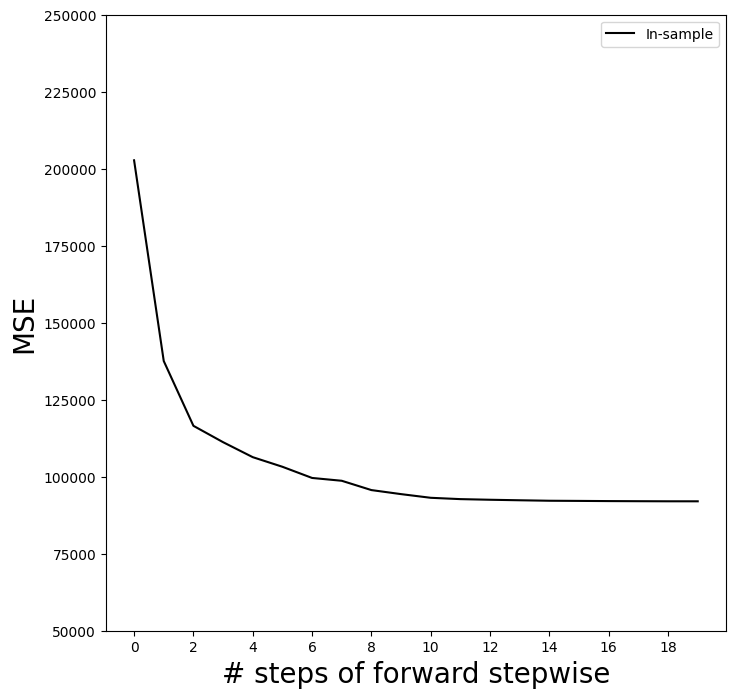

In [12]:
mse_fig, ax = subplots(figsize=(8,8))
insample_mse = ((Yhat_in- Y[:,None])**2).mean(0)
n_steps = insample_mse.shape[0]
ax.plot(np.arange(n_steps),
        insample_mse,
        'k', # color black
        label='In-sample')
ax.set_ylabel('MSE', fontsize=20)
ax.set_xlabel('# steps of forward stepwise', fontsize=20)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax.set_ylim([50000,250000]);

Yukarıda Y[:, None] ifadesine dikkat edin. Bu, tek boyutlu Y dizisine bir eksen (boyut) ekler ve böylece iki boyutlu Yhat_in’den çıkarıldığında yeniden kullanılmasını sağlar.

Artık model yolu boyunca test hatasını tahmin etmek için çapraz doğrulamayı kullanmaya hazırız. Tüm model kurma aşamalarını — değişken seçimi dahil — yalnızca eğitim gözlemleri kullanarak gerçekleştirmeliyiz. Bu nedenle, belirli bir boyuttaki en iyi modelin belirlenmesi, her eğitim katmanındaki yalnızca eğitim gözlemleri kullanılarak yapılmalıdır. Bu nokta ince ama önemlidir. Eğer her adımda en iyi alt küme seçimi için tüm veri seti kullanılırsa, elde edeceğimiz doğrulama seti hataları ve çapraz doğrulama hataları test hatasının doğru tahminleri olmayacaktır.

Şimdi 5 katlı çapraz doğrulama kullanarak çapraz doğrulanmış tahmin değerlerini hesaplıyoruz.


In [13]:
K = 5
kfold = skm.KFold(K,
                    random_state=0,
                    shuffle=True)
Yhat_cv = skm.cross_val_predict(full_path,
                                Hitters,
                                Y,
                                cv=kfold)
Yhat_cv.shape

(263, 20)

Tahmin matrisi Yhat_cv, Yhat_in ile aynı şekildedir; fark, her satırdaki tahminlerin, o satırı içermeyen bir eğitim katmanında kurulan modellerden elde edilmiş olmasıdır.

Model yolundaki her model için, her çapraz doğrulama katmanında MSE hesaplanır. Bu değerler ortalanarak ortalama MSE elde edilir ve ayrıca bireysel değerler kullanılarak ortalamanın kaba bir standart hata tahmini de yapılabilir. Bu nedenle, her çapraz doğrulama bölmesi için test indekslerini bilmemiz gerekir. Bunlar, kfold’un split() yöntemi kullanılarak bulunabilir. Yukarıda rastgele durumu sabitlediğimiz için, Y ile aynı sayıda satıra sahip herhangi bir diziyi böldüğümüzde aynı eğitim ve test indekslerini elde ederiz; aşağıda ise eğitim indekslerini dikkate almayacağız.


In [14]:
cv_mse = []
for train_idx, test_idx in kfold.split(Y):
    errors = (Yhat_cv[test_idx]- Y[test_idx,None])**2
    cv_mse.append(errors.mean(0)) # column means
cv_mse = np.array(cv_mse).T
cv_mse.shape

(20, 5)

Artık çapraz doğrulama hata tahminlerini MSE grafiğimize ekliyoruz. Beş katlı ortalama hatayı ve ortalamanın standart hata tahminini de dahil ediyoruz.


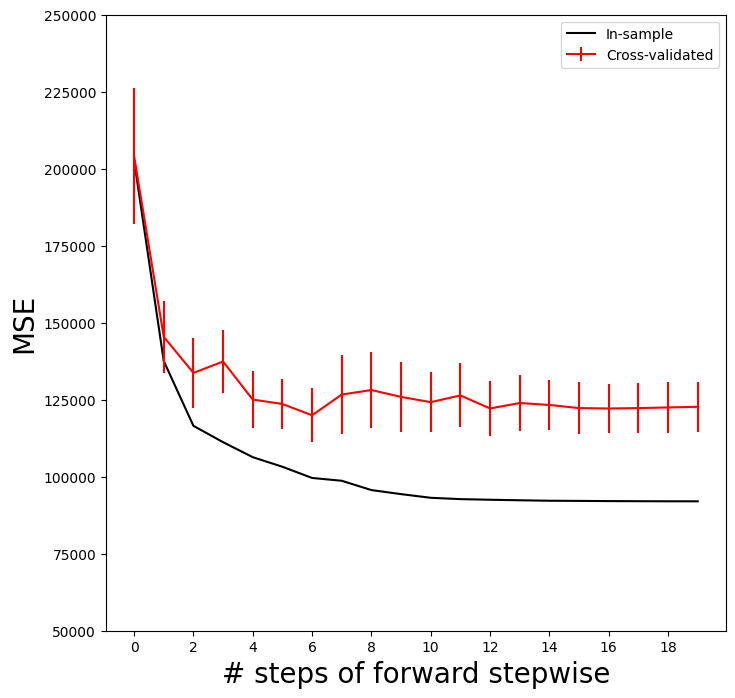

In [15]:
ax.errorbar(np.arange(n_steps),
    cv_mse.mean(1),
    cv_mse.std(1) / np.sqrt(K),
    label='Cross-validated',
    c='r') # color red
ax.set_ylim([50000,250000])
ax.legend()
mse_fig

Yukarıdakini doğrulama seti yaklaşımını kullanarak tekrarlamak için, yalnızca cv argümanımızı bir doğrulama seti ile değiştiririz: veriyi rastgele bir şekilde eğitim ve test olarak böleriz. Test boyutu olarak %20 seçiyoruz; bu, 5 katlı çapraz doğrulamadaki her test setinin boyutuna benzer.


In [16]:
validation = skm.ShuffleSplit(n_splits=1,
                                test_size=0.2,
                                random_state=0)
for train_idx, test_idx in validation.split(Y):
    full_path.fit(Hitters.iloc[train_idx],
                    Y[train_idx])
    Yhat_val = full_path.predict(Hitters.iloc[test_idx])
    errors = (Yhat_val- Y[test_idx,None])**2
    validation_mse = errors.mean(0)

Örnek içi MSE durumunda olduğu gibi, doğrulama seti yaklaşımı standart hatalar sağlamaz.


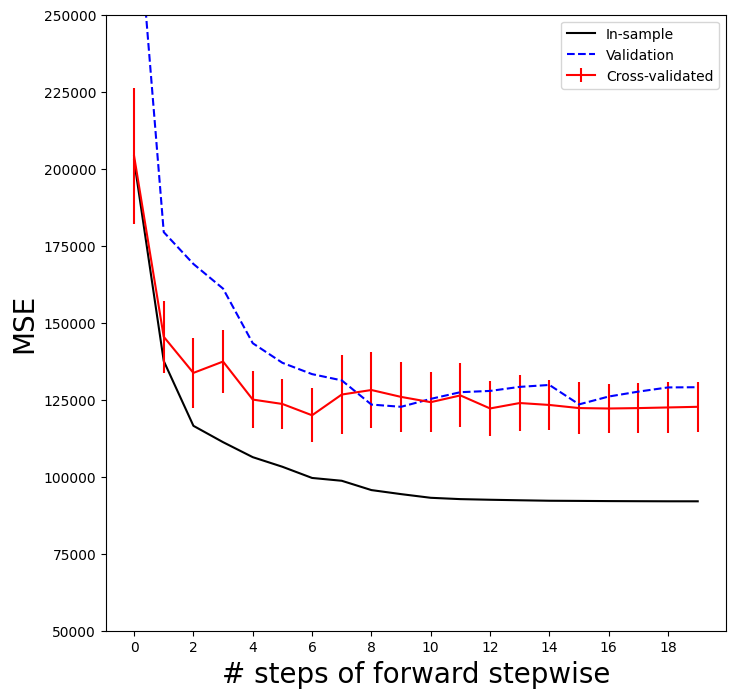

In [17]:
ax.plot(np.arange(n_steps),
        validation_mse,
        'b--', # color blue, broken line
        label='Validation')
ax.set_xticks(np.arange(n_steps)[::2])
ax.set_ylim([50000,250000])
ax.legend()
mse_fig

## En İyi Alt Küme Seçimi

İleriye doğru stepwise, açgözlü bir seçim prosedürüdür; her adımda mevcut kümeye bir ek değişken dahil eder. Şimdi Hitters verisine en iyi alt küme seçimini uygulayacağız; bu yöntem, her alt küme boyutu için en iyi öngörücü setini arar.

En iyi alt küme seçimini gerçekleştirmek için l0bnb adlı bir paket kullanacağız. Bu paket, alt kümeyi belirli bir boyutla sınırlamak yerine, alt küme boyutunu bir kısıtlama yerine ceza olarak kullanarak bir çözüm yolu üretir. Ayrım ince olsa da, fark çapraz doğrulama yapıldığında ortaya çıkar.

In [18]:
D = design.fit_transform(Hitters)
D = D.drop('intercept', axis=1)
X = np.asarray(D)

Burada, l0bnb kesişim terimini ayrı olarak uyarlayacağından, kesişim terimine karşılık gelen ilk sütunu çıkardık. Bir çözüm yolu fit_path() fonksiyonu ile bulunabilir.


In [19]:
path = fit_path(X,
                Y,
                max_nonzeros=X.shape[1])

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2
Iteration: 3. Number of non-zeros:  2
Iteration: 4. Number of non-zeros:  2
Iteration: 5. Number of non-zeros:  3
Iteration: 6. Number of non-zeros:  3
Iteration: 7. Number of non-zeros:  4
Iteration: 8. Number of non-zeros:  9
Iteration: 9. Number of non-zeros:  9
Iteration: 10. Number of non-zeros:  9
Iteration: 11. Number of non-zeros:  9
Iteration: 12. Number of non-zeros:  9
Iteration: 13. Number of non-zeros:  9
Iteration: 14. Number of non-zeros:  9
Iteration: 15. Number of non-zeros:  9
Iteration: 16. Number of non-zeros:  9
Iteration: 17. Number of non-zeros:  9
Iteration: 18. Number of non-zeros:  17
Iteration: 19. Number of non-zeros:  19


fit_path() fonksiyonu, B olarak uyarlanmış katsayıları, B0 olarak bir kesişim terimini ve kullanılan özel yol algoritmasıyla ilgili birkaç başka özniteliği içeren bir liste döndürür. Bu tür detaylar bu kitabın kapsamının dışındadır.


In [20]:
path[3]

{'B': array([0.        , 3.25484367, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.67775265, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 'B0': -38.98216739555505,
 'lambda_0': 0.011416248027450187,
 'M': 0.5829861733382012,
 'Time_exceeded': False}

Yukarıdaki örnekte, yolun dördüncü adımında, ceza parametresi lambda_0 için 0.114 değerine karşılık gelen B’de iki sıfırdan farklı katsayı olduğunu görüyoruz. Bu uyum dizisini kullanarak lambda_0 fonksiyonu olarak doğrulama setinde tahminler yapabiliriz veya daha fazla çalışma ile çapraz doğrulama kullanabiliriz.


# 6.5.2 Ridge Regression and the Lasso